In [6]:
# Standard modules
import pickle as pkl
import numpy as np
import heapq as hq
from icecream import ic
# PyTorch
import torch
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.layouts import row
output_notebook()
# Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
# Modules from local files
from GNN_mol import GNN
from utils import bokeh_spectra, calculate_rse, plot_spectra

Loading BokehJS ...

In [2]:
def pred_spec(model, index, test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

### Coronene

#### Set model value

In [3]:
num_tasks = 200
num_layers = 3
emb_dim = 10
in_channels = [int(emb_dim), 100, 200]
out_channels = [100, 200, 200]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_name = 'model_gnn_test.pt'

#### Load the saved model

In [7]:
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name))

<All keys matched successfully>

#### Load the test data

In [8]:
test_dataset = torch.load("./test.pt")

FileNotFoundError: [Errno 2] No such file or directory: './test.pt'

#### Use model to predict from test data

In [14]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

# Parse spectra into dictionary
model_dict = [predict, true]

# Save prediction results to file
name = 'spectra_ml_test.pkl'

with open("spectra_results/" + name, "wb") as file:
    pkl.dump(model_dict, file)

#### View predictions

In [15]:
file = open('spectra_results/' + name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

#### Perform analysis of predictions

In [16]:
wasser = []
mse = []
rse = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(predict[x], true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(predict[x], true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(predict[x], true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.04575181715071488
Average MSE = 0.00721534747150356
Average RSE = 0.040320597496068436


In [17]:
five_best = hq.nsmallest(5, rse)
five_worst = hq.nlargest(5, rse)

best = []
worst = []

for x in range(5):
    best_idx = rse.index(five_best[x])
    best.append(best_idx)

    worst_idx = rse.index(five_worst[x])
    worst.append(worst_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {five_best[x]:.3f}, graph number = {best[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(5):
    print(f'RSE = {five_worst[x]:.3f}, graph number = {worst[x]}')

The 5 best RSE values are:
RSE = 0.021, graph number = 33
RSE = 0.027, graph number = 27
RSE = 0.028, graph number = 12
RSE = 0.028, graph number = 14
RSE = 0.029, graph number = 16

The 5 worst RSE values are:
RSE = 0.077, graph number = 36
RSE = 0.065, graph number = 19
RSE = 0.059, graph number = 26
RSE = 0.054, graph number = 25
RSE = 0.053, graph number = 4


#### View and compare predictions

In [18]:
# Plot best spectra prediction
p1 = bokeh_spectra(predict[best[0]], true[best[0]])
p2 = bokeh_spectra(predict[best[1]], true[best[1]])
p3 = bokeh_spectra(predict[best[2]], true[best[2]])
p = row(p1, p2, p3)
show(p)
#export_svg(p, filename='test.svg')

In [19]:
# Plot worst spectra prediction
p1 = bokeh_spectra(predict[worst[0]], true[worst[0]])
p2 = bokeh_spectra(predict[worst[1]], true[worst[1]])
p3 = bokeh_spectra(predict[worst[2]], true[worst[2]])
p = row(p1, p2, p3)
show(p)

### Circumcoronene

#### Load the circumcoronene dataset

In [8]:
circum_dataset = torch.load('./processed/data_mol_circumcor.pt')

In [10]:
# Show details of the dataset
print(circum_dataset)
print('-------------')
print(f'Number of graphs: {len(circum_dataset)}')
print(f'Number of features: {circum_dataset.num_features}')
print(f'Number of classes: {circum_dataset.num_classes}')
print('')

# Show details of the first molecule/graph in the dataset
circum_data = circum_dataset[1]

print(circum_data)
print('---------------')
print(f'Number of nodes: {circum_data.num_nodes}')
print(f'Number of edges: {circum_data.num_edges}')
print(f'Average node degree: {circum_data.num_edges / circum_data.num_nodes:.2f} ')
print(f'Has isolated nodes: {circum_data.has_isolated_nodes()}')
print(f'Has self loops: {circum_data.has_self_loops()}')
print(f'Is undirected: {circum_data.is_undirected()}')

XASDataset(91)
-------------
Number of graphs: 91
Number of features: 10
Number of classes: 18110

Data(x=[59, 10], edge_index=[2, 156], y=[200], weight=[156, 6], smiles='[c:0]12[c:1]3[c:6]4[c:7]5[c:8]6[c:13]7[c:12]8[c:11]9[c:10]5[c:26]5[c:25]%10[c:24]4[c:23]([cH:22]1)[C@H:31]1[C@@H:32]([c:33]%10[cH:34][c:35]4[c:27]5[c:28]5[c:14]9[c:15]9[c:16]%10[c:17]8[c:44]8[c:43]%11[c:42]7[c:41]7[c:40]%12[c:39]([cH:47][cH:48][c:49]7[cH:50][c:51]%11=[CH:52][C:53](=[O:54])[C:45]=8[CH2:46][C@:21]%10([OH:56])[CH:20]=[CH:19][c:18]9[cH:30][c:29]5[cH:37][cH:36]4)=[CH:38][C@:3]([OH:58])([C@H:2]3[C@:9]6%12[OH:57])[CH:4]=[CH:5]2)[O:55]1')
---------------
Number of nodes: 59
Number of edges: 156
Average node degree: 2.64 
Has isolated nodes: False
Has self loops: False
Is undirected: True


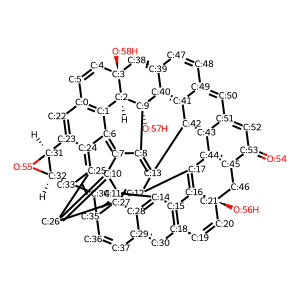

In [11]:
mol = Chem.MolFromSmiles(circum_data.smiles)
mol

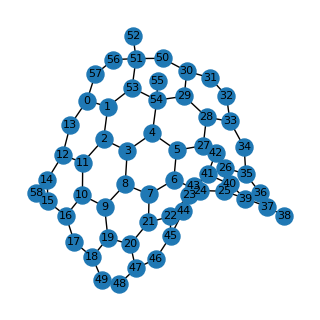

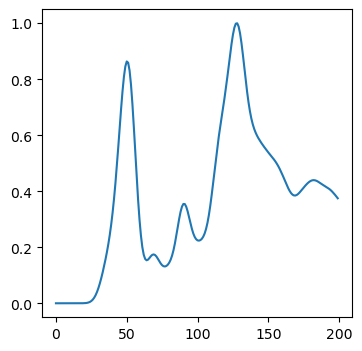

In [17]:
# Show graph representation of molecule
mol_graph = to_networkx(circum_data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(circum_data.y)

plt.show()

#### Load the model

In [21]:
num_tasks = 200
num_layers = 3
emb_dim = 10
in_channels = [int(emb_dim), 100, 200]
out_channels = [100, 200, 200]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"

model_name = 'model_gnn_test.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name))

<All keys matched successfully>

In [25]:
cir_predict = {}
cir_true = {}

for index in range(len(circum_dataset)):
    cir_predict[index], cir_true[index] = pred_spec(model, index, circum_dataset)

# Parse spectra into dictionary
cir_model_dict = [cir_predict, cir_true]

name = 'cir_spectra_ml_test.pkl'

with open('spectra_results/' + name, 'wb') as file:
    pkl.dump(cir_model_dict, file)

In [26]:
file = open('spectra_results/' + name, 'rb')
cir_data = pkl.load(file)

cir_predict = cir_data[0]
cir_true = cir_data[1]

In [28]:
wasser = []
mse = []
rse = []

for x in range(len(cir_predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(cir_predict[x], cir_true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(cir_predict[x], cir_true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(cir_predict[x], cir_true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.05666137581703436
Average MSE = 0.007637249931385032
Average RSE = 0.053221513989234505


In [29]:
five_best = hq.nsmallest(5, rse)
five_worst = hq.nlargest(5, rse)

best = []
worst = []

for x in range(5):
    best_idx = rse.index(five_best[x])
    best.append(best_idx)

    worst_idx = rse.index(five_worst[x])
    worst.append(worst_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {five_best[x]:.3f}, graph number = {best[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(5):
    print(f'RSE = {five_worst[x]:.3f}, graph number = {worst[x]}')

The 5 best RSE values are:
RSE = 0.024, graph number = 85
RSE = 0.027, graph number = 29
RSE = 0.030, graph number = 42
RSE = 0.030, graph number = 64
RSE = 0.030, graph number = 7

The 5 worst RSE values are:
RSE = 0.103, graph number = 22
RSE = 0.085, graph number = 82
RSE = 0.083, graph number = 4
RSE = 0.080, graph number = 18
RSE = 0.076, graph number = 56


In [30]:
# Plot best spectra prediction
p1 = bokeh_spectra(cir_predict[best[0]], cir_true[best[0]])
p2 = bokeh_spectra(cir_predict[best[1]], cir_true[best[1]])
p3 = bokeh_spectra(cir_predict[best[2]], cir_true[best[2]])
p = row(p1, p2, p3)
show(p)
#export_svg(p, filename='test.svg')

In [32]:
# Plot best spectra prediction
p1 = bokeh_spectra(cir_predict[worst[0]], cir_true[worst[0]])
p2 = bokeh_spectra(cir_predict[worst[1]], cir_true[worst[1]])
p3 = bokeh_spectra(cir_predict[worst[2]], cir_true[worst[2]])
p = row(p1, p2, p3)
show(p)
#export_svg(p, filename='test.svg')